## Problem Definition 

The goal of this project is to analyze and address the challenges associated with loan defaults in the context of our lending institution. By leveraging data analysis and predictive modeling techniques, the project aims to optimize the loan approval process and reduce the risk of defaults.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier  
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler,SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler


## Data Insights 

In [2]:
df = pd.read_csv('data/Loan_Default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [4]:
df.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [5]:
df.duplicated().value_counts()

False    148670
dtype: int64

There is no duplicates in data 

In [6]:
df.columns = [col.lower() for col in df.columns]  #to standartize it 
print(df.columns) 

Index(['id', 'year', 'loan_limit', 'gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'credit_worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'interest_rate_spread', 'upfront_charges', 'term', 'neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'secured_by', 'total_units',
       'income', 'credit_type', 'credit_score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'ltv', 'region', 'security_type',
       'status', 'dtir1'],
      dtype='object')


Find the number of null values for each column 

In [7]:
df.isnull().sum()


id                               0
year                             0
loan_limit                    3344
gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
credit_worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
interest_rate_spread         36639
upfront_charges              39642
term                            41
neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
secured_by                       0
total_units                      0
income                        9150
credit_type                      0
credit_score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [8]:
(df.isnull().sum()/len(df))*100

id                            0.000000
year                          0.000000
loan_limit                    2.249277
gender                        0.000000
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
credit_worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
rate_of_interest             24.509989
interest_rate_spread         24.644515
upfront_charges              26.664425
term                          0.027578
neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
construction_type             0.000000
occupancy_type                0.000000
secured_by                    0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
credit_score             

+ Given the above missing data information, I want to have a dual approach of column-specific imputation coupled with pipeline integration. For columns with substantial missing values, such as rate_of_interest, Interest_rate_spread, Upfront_charges, property_value, LTV, and dtir1, an in-depth analysis to determine the appropriate imputation method is better.

+ Then, I plan to systematize the chosen imputation methods within a ColumnTransformer, ensuring a consistent and automated application of these methods to both the training and testing sets.






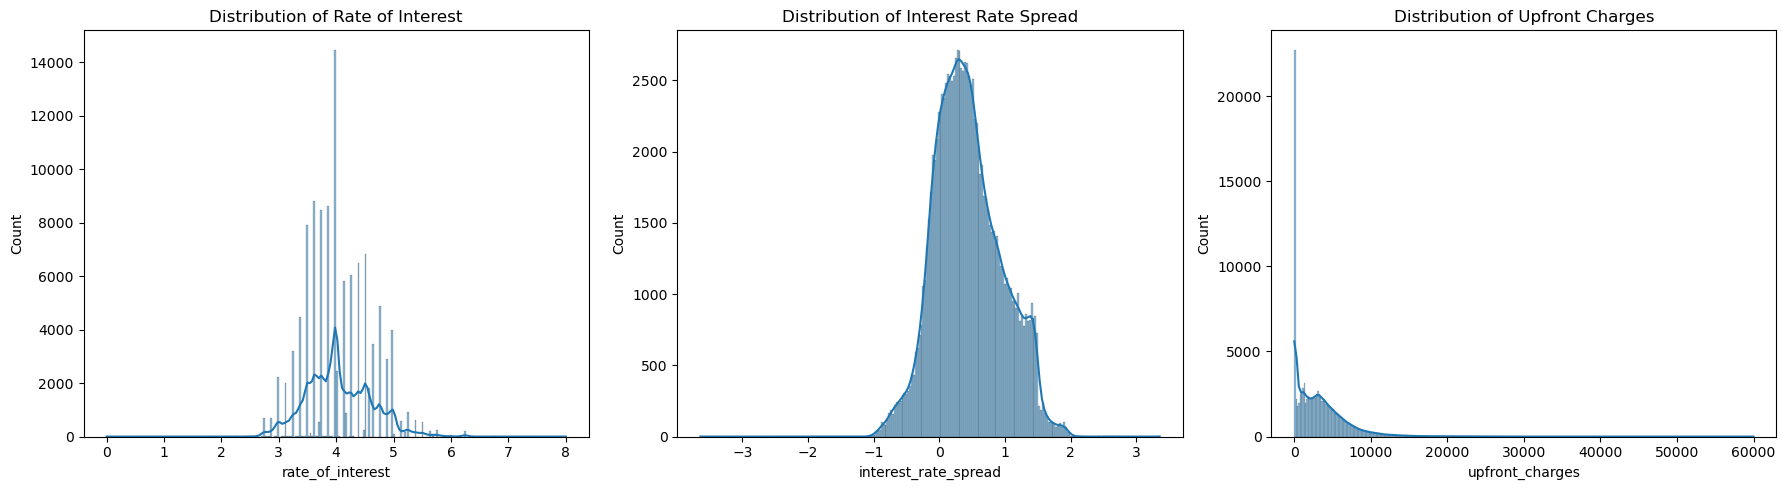

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure with a specified figure size
plt.figure(figsize=(18, 5))

# Histogram for 'rate_of_interest'
plt.subplot(1, 3, 1)  # (rows, columns, panel number)
sns.histplot(df['rate_of_interest'].dropna(), kde=True)
plt.title('Distribution of Rate of Interest')

# Histogram for 'interest_rate_spread'
plt.subplot(1, 3, 2)
sns.histplot(df['interest_rate_spread'].dropna(), kde=True)
plt.title('Distribution of Interest Rate Spread')

# Histogram for 'upfront_charges'
plt.subplot(1, 3, 3)
sns.histplot(df['upfront_charges'].dropna(), kde=True)
plt.title('Distribution of Upfront Charges')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



Explanation of above histograms: 
+ The "Rate of Interest" and "Interest Rate Spread" features, exhibiting normal distributions, are well-suited for mean imputation when addressing missing values. The mean is a reliable indicator of central tendency for symmetric distributions, offering a balanced central point that reflects the typical values of these features.

+ Conversely, "Upfront Charges" display a right-skewed distribution, suggesting that a significant number of very high values are pulling the mean to the right. Therefore, the median, which is not swayed by such outliers, is a better choice for imputation. Using the median ensures that the imputed values align more closely with the most common range of the data, preserving its original distributional characteristics.

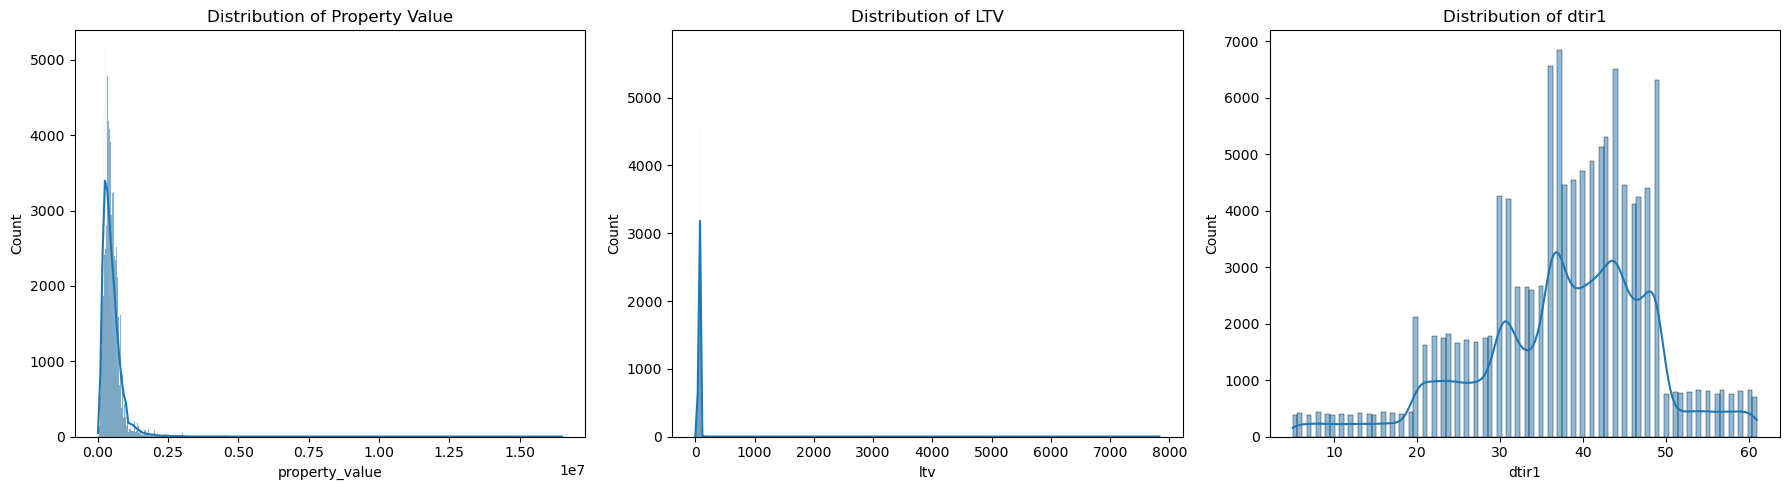

In [10]:
# Set up the matplotlib figure with a specified figure size
plt.figure(figsize=(18, 5))

# Histogram for 'property_value'
plt.subplot(1, 3, 1)  # (rows, columns, panel number)
sns.histplot(df['property_value'].dropna(), kde=True)
plt.title('Distribution of Property Value')

# Histogram for 'LTV'
plt.subplot(1, 3, 2)
sns.histplot(df['ltv'].dropna(), kde=True)
plt.title('Distribution of LTV')

# Histogram for 'dtir1'
plt.subplot(1, 3, 3)
sns.histplot(df['dtir1'].dropna(), kde=True)
plt.title('Distribution of dtir1')


# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


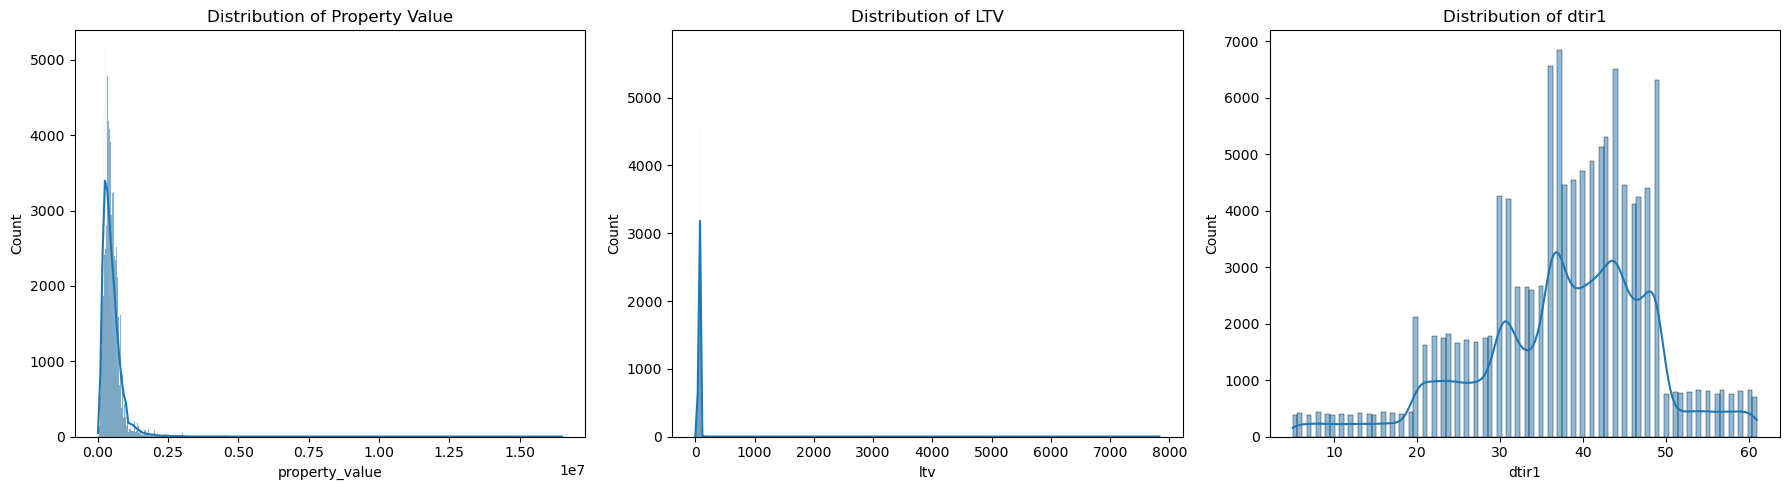

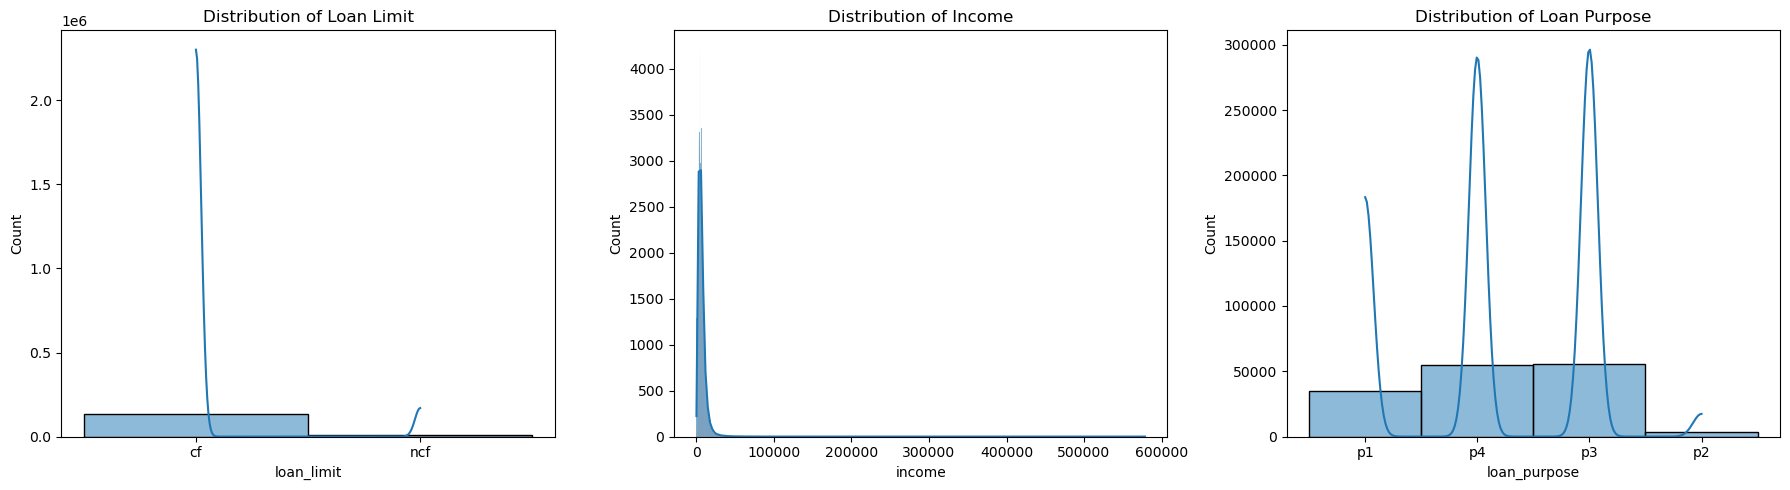

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(18, 5))

# Create the first set of subplots
plt.subplot(1, 3, 1)  # First subplot
sns.histplot(df['property_value'].dropna(), kde=True)
plt.title('Distribution of Property Value')

plt.subplot(1, 3, 2)  # Second subplot
sns.histplot(df['ltv'].dropna(), kde=True)
plt.title('Distribution of LTV')

plt.subplot(1, 3, 3)  # Third subplot
sns.histplot(df['dtir1'].dropna(), kde=True)
plt.title('Distribution of dtir1')

# Adjust the layout for the first set of subplots
plt.tight_layout()

# Display the first set of subplots
plt.show()

# Create the second set of subplots
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # First subplot
sns.histplot(df['loan_limit'].dropna(), kde=True)
plt.title('Distribution of Loan Limit')

plt.subplot(1, 3, 2)  # Second subplot
sns.histplot(df['income'].dropna(), kde=True)
plt.title('Distribution of Income')

plt.subplot(1, 3, 3)  # Third subplot
sns.histplot(df['loan_purpose'].dropna(), kde=True)
plt.title('Distribution of Loan Purpose')

# Adjust the layout for the second set of subplots
plt.tight_layout()

# Display the second set of subplots
plt.show()


* We will have the similar approach explained for previous histograms. Detailed operations will be performed in the preprocess stage. 

## Data Insights- Visualizations

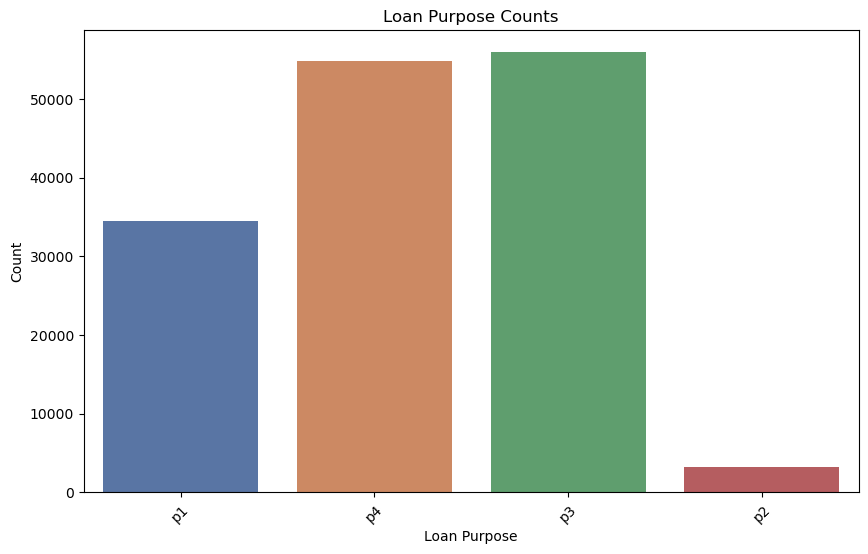

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_purpose', palette='deep')
plt.title('Loan Purpose Counts')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45)  

# Show the plot
plt.show()

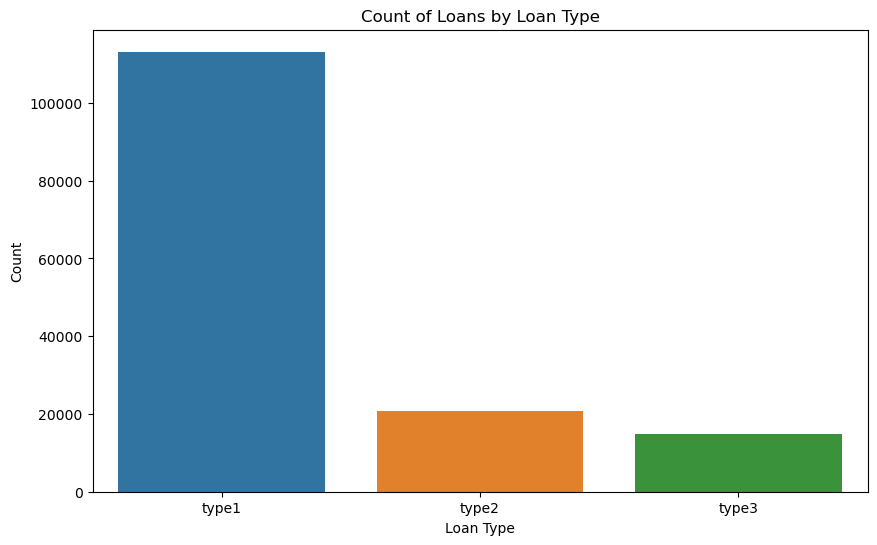

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_type')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.title('Count of Loans by Loan Type')
plt.show()


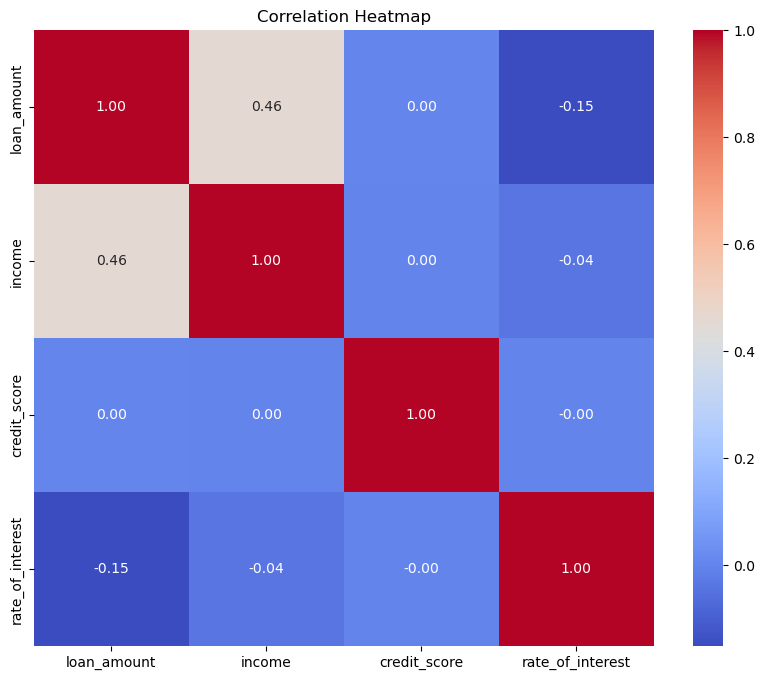

In [16]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[['loan_amount', 'income', 'credit_score', 'rate_of_interest']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

These variables were chosen based on their importance in the context of loans and financial analysis. The goal is to gain insights into relationships and patterns within the data that are relevant to  analysis goals.

## Data Cleaning 

**Gender Column:** Due to ethical considerations and potential legal restrictions (like those from the Equal Credit Opportunity Act in the U.S.), using gender as a predictor in loan default models is generally discouraged and could be considered discriminatory. Then drop the gender column.

In [17]:
# Drop the columns
df = df.drop(columns='gender')

**Year Column:**  Let's analyze the effects of years. 

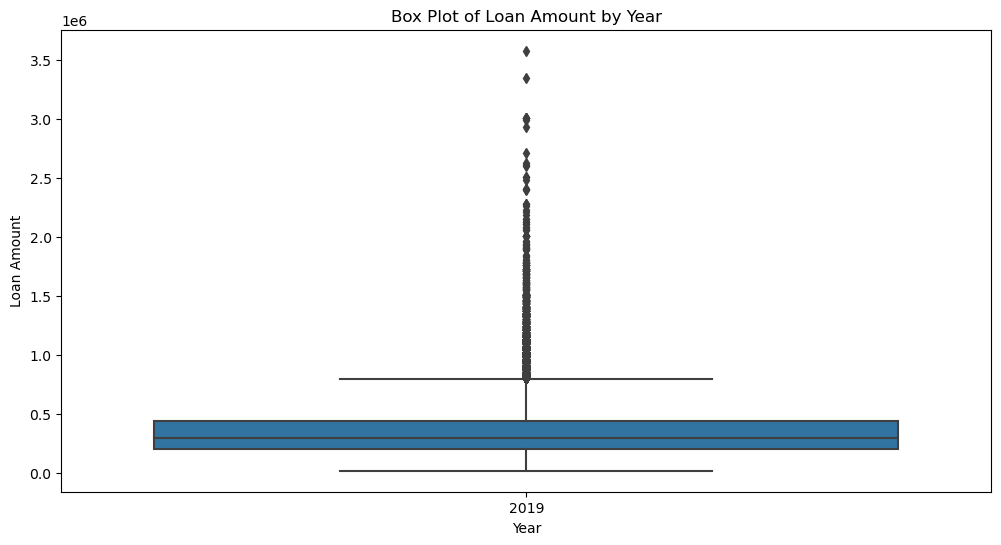

In [18]:
# Create a box plot for 'loan_amount' by year
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.boxplot(x='year', y='loan_amount', data=df)
plt.xlabel('Year')  # Set x-axis label
plt.ylabel('Loan Amount')  # Set y-axis label
plt.title('Box Plot of Loan Amount by Year')  # Set plot title

plt.show()



Above boxplot shows that the data mainly has the info from 2019. Lets check whether there is an outlier. 

In [19]:
 #Filter rows where 'year' is different from 2019
different_years = df[df['year'] != 2019]

# Count the number of rows
count_different_years = len(different_years)

# Print the count and the IDs
print(f"Number of rows with year different from 2019: {count_different_years}")


Number of rows with year different from 2019: 0


So, there is only one spesific year, 2019,  therefore we cannot use year in time-analysis. Drop it. Also drop ID. 



In [20]:
columns_to_drop = ['id', 'year']
# Drop the columns
df = df.drop(columns=columns_to_drop)

 - Quick check for the important features. 
 
**Note:** Note that this is not a modelling, I just want a quick insight for the features so maybe I can reduce the features. 

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the absolute correlation values with the 'Status' column
correlation_with_target = abs(correlation_matrix['status'])

# Sort the features by their correlation values in descending order
sorted_features = correlation_with_target.sort_values(ascending=False)

# Print the top N features (e.g., top 10)
top_features = sorted_features.head(10)
print("Top Features by Correlation with 'Status':")
print(top_features)


Note hat correlation does not imply causation, and the strength of correlation may not necessarily mean that a feature is important for predicting the target variable.

## Quick Summary until now 

- Gender, ID, year are dropped. 
- There are missing values and I will fill these values in a Pipeline in the modelling stage.  

## Age is object!

Credit Behavior by Age Group: Different age groups might exhibit distinct credit behaviors. For example, younger borrowers might have a different default risk compared to older ones due to factors like job stability, income levels, and financial obligations.

In [21]:
# Convert age ranges to ordinal values
# Convert all entries in 'age' to strings and handle NaN values
df['age'] = df['age'].astype(str)

df['age'] = df['age'].replace('nan', 'unknown')

# Now we can sort the unique age range strings and create the ordinal mapping
age_ranges = sorted(df['age'].unique())
ordinal_age_mapping = {age_range: index for index, age_range in enumerate(age_ranges)}
df['age_ordinal'] = df['age'].map(ordinal_age_mapping)



**Remark: ** Note that the alternative approach to above code is creating a pipeline as below:
*** 
#Define the encoding for the ordinal 'age' column

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[age_ranges]))  
])
***

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   approv_in_adv              147762 non-null  object 
 2   loan_type                  148670 non-null  object 
 3   loan_purpose               148536 non-null  object 
 4   credit_worthiness          148670 non-null  object 
 5   open_credit                148670 non-null  object 
 6   business_or_commercial     148670 non-null  object 
 7   loan_amount                148670 non-null  int64  
 8   rate_of_interest           112231 non-null  float64
 9   interest_rate_spread       112031 non-null  float64
 10  upfront_charges            109028 non-null  float64
 11  term                       148629 non-null  float64
 12  neg_ammortization          148549 non-null  object 
 13  interest_only              14

In [23]:
# Drop the original age column 
df = df.drop(columns=['age'])

In [24]:
# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()

# Confirm the lists of categorical and numerical columns
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)


Categorical Columns:
['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'submission_of_application', 'region', 'security_type']

Numerical Columns:
['loan_amount', 'rate_of_interest', 'interest_rate_spread', 'upfront_charges', 'term', 'property_value', 'income', 'credit_score', 'ltv', 'status', 'dtir1', 'age_ordinal']


## Preprocessing 

In [25]:
from sklearn.impute import SimpleImputer

# Separate columns with different imputation strategies
columns_to_fill_with_mean = ['rate_of_interest', 'interest_rate_spread', 'dtir1']
columns_to_fill_with_median = ['upfront_charges', 'property_value', 'ltv', 'income']

# Impute columns that need mean imputation
mean_imputer = SimpleImputer(strategy='mean')
df[columns_to_fill_with_mean] = mean_imputer.fit_transform(df[columns_to_fill_with_mean])

# Impute columns that need median imputation
median_imputer = SimpleImputer(strategy='median')
df[columns_to_fill_with_median] = median_imputer.fit_transform(df[columns_to_fill_with_median])



In [ ]:
(df.isnull().sum()/len(df))*100

**Note:** I will create a pipeline for the remaining preprocessing steps, including handling the remaining missing values. 

## Dummy Classifier

In [26]:
class EvaluationMetrics:
    #model_df =[]
    model_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Train Recall', 'Train Precision', 'Train F1-Score',
                                              'Train Log Loss','Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1-Score',
                                              'Test Log Loss', 'Validation Accuracy', 'Validation Recall', 'Validation Precision',
                                              'Validation F1-Score'])

    def __init__(self, pipe, X_train, X_test, y_train, y_test, X_val, y_val):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        y_train_pred_proba = self.pipe.predict_proba(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted'),
                              'log_loss': log_loss(self.y_train, y_train_pred_proba)}

        # Test set predictions
        y_test_pred = self.pipe.predict(self.X_test)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        test_results_dict = {'accuracy': accuracy_score(self.y_test, y_test_pred),
                             'recall': recall_score(self.y_test, y_test_pred, average='weighted'),
                             'precision': precision_score(self.y_test, y_test_pred, average='weighted'),
                             'f1_score': f1_score(self.y_test, y_test_pred, average='weighted'),
                             'log_loss': log_loss(self.y_test, y_test_pred_proba)}

        # Validation set predictions
        y_val_pred = self.pipe.predict(self.X_val)
        y_val_pred_proba = self.pipe.predict_proba(self.X_val)
        val_results_dict = {'accuracy': accuracy_score(self.y_val, y_val_pred),
                            'recall': recall_score(self.y_val, y_val_pred, average='weighted'),
                            'precision': precision_score(self.y_val, y_val_pred, average='weighted'),
                            'f1_score': f1_score(self.y_val, y_val_pred, average='weighted'),
                            'log_loss': log_loss(self.y_val, y_val_pred_proba)}

        return train_results_dict, test_results_dict, val_results_dict

    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)

    # Plots ROC curve for all classes
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()

    # Plots confusion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

    def record_results(self, model_name, train_results, test_results, val_results):
        new_row = {'Model': model_name,
               'Train Accuracy': train_results['accuracy'],
               'Train Recall': train_results['recall'],
               'Train Precision': train_results['precision'],
               'Train F1-Score': train_results['f1_score'],
               'Train Log Loss': train_results['log_loss'],
               'Test Accuracy': test_results['accuracy'],
               'Test Recall': test_results['recall'],
               'Test Precision': test_results['precision'],
               'Test F1-Score': test_results['f1_score'],
               'Test Log Loss': test_results['log_loss'],
               'Validation Accuracy': val_results['accuracy'],
               'Validation Recall': val_results['recall'],
               'Validation Precision': val_results['precision'],
               'Validation F1-Score': val_results['f1_score'],
               'Validation Log Loss': val_results['log_loss']}
        new_row_df= pd.DataFrame(new_row, index=[0])
        self.model_df = pd.concat([self.model_df, new_row_df],ignore_index=True)

        # self.model_df.loc[len(self.model_df)] = new_row
        # results = pd.concat([self.model_df, results, results_1], ignore_index =True)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss, roc_curve


# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop('status', axis=1),  # Drop the target variable to create features
    df['status'],               # Target variable
    random_state=0,             # Ensures reproducibility
    test_size=0.4,              # Proportion of dataset to include in initial train split
    stratify=df['status'],      # Ensures train and test sets have similar class distributions
    shuffle=True                # Shuffles the data before splitting
)

# Further split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    random_state=0,             # Ensures reproducibility
    test_size=0.5,              # Proportion of dataset to include in validation split
    stratify=y_temp,            # Ensures validation and test sets have similar class distributions
    shuffle=True                # Shuffles the data before splitting
)

# Create a pipeline with a dummy classifier
pipeline_dummy = Pipeline([
    ('dummy_classifier', DummyClassifier(strategy='most_frequent'))  # You can choose different strategies
])

# Train the pipeline (dummy classifier)
pipeline_dummy.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_dummy.predict(X_test)

# Calculate accuracy as a baseline metric (replace with appropriate evaluation metrics)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dummy Classifier Accuracy: {accuracy:.2f}")

# Now you can use EvaluationMetrics with X_train, X_test, y_train, y_test, X_val, y_val
dummy_metrics = EvaluationMetrics(pipeline_dummy, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = dummy_metrics.print_scores()
dummy_metrics.record_results('DummyModel', train_results, test_results, val_results)


Dummy Classifier Accuracy: 0.75


In [28]:
dummy_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.753559,0.753559,0.567852,0.647656,8.511759,0.753548,0.753548,0.567835,0.647641,8.512146,0.753548,0.753548,0.567835,0.647641,8.512146


## Logistic regression

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('status', axis=1),  # Drop the target variable to create features
    df['status'],               # Target variable
    random_state=0,             # Ensures reproducibility
    test_size=0.2,              # Proportion of dataset to include in test split
    stratify=df['status'],      # Ensures train and test sets have similar class distributions
    shuffle=True                # Shuffles the data before splitting
)

# Define categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Include SMOTE in your pipeline after preprocessing and before the classifier
pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the pipeline
pipeline_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.84


In [ ]:
# See the features after encoding 

In [36]:
from sklearn.preprocessing import OneHotEncoder

# Create the OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the encoder on the categorical features
encoded_data = onehot_encoder.fit_transform(X_train[categorical_features])

# Convert the result to a DataFrame for easier inspection
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=onehot_encoder.get_feature_names(categorical_features))

# Display the first few rows of the encoded DataFrame
encoded_df.head()
)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118936 entries, 0 to 118935
Data columns (total 53 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   loan_limit_cf                       118936 non-null  float64
 1   loan_limit_ncf                      118936 non-null  float64
 2   loan_limit_nan                      118936 non-null  float64
 3   approv_in_adv_nopre                 118936 non-null  float64
 4   approv_in_adv_pre                   118936 non-null  float64
 5   approv_in_adv_nan                   118936 non-null  float64
 6   loan_type_type1                     118936 non-null  float64
 7   loan_type_type2                     118936 non-null  float64
 8   loan_type_type3                     118936 non-null  float64
 9   loan_purpose_p1                     118936 non-null  float64
 10  loan_purpose_p2                     118936 non-null  float64
 11  loan_purpose_p3           

### Grid search for logistic regression

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__max_iter': [100, 200, 300]
}

# Create GridSearchCV object
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

print("Best Hyperparameters:")
print(best_params)
print("Best Score (Accuracy):", best_score)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

## Target values 

In [ ]:
df["loan_status"].value_counts(normalize=True)

So the data is imbalance and we need to consider this for modelling steps. 

## Preprocessing 

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Assuming df is your dataframe and 'Status' is the target variable
X = df.drop(['ID', 'Status'], axis=1)
y = df['Status']

# Identify categorical columns that need to be encoded
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names(input_features=categorical_cols)

# Combine feature importances with their corresponding feature names
importances = dict(zip(feature_names, feature_importances))

# Sort the feature importances in descending order and print them
sorted_importances = sorted(importances.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


## Data Cleaning  
Due to ethical considerations and potential legal restrictions (like those from the Equal Credit Opportunity Act in the U.S.), using gender as a predictor in loan default models is generally discouraged and could be considered discriminatory.

In [ ]:
df['age'] = df['age'].str.extract('(\d+)').astype(float)

In [ ]:
print(df.columns)

In [ ]:
columns_to_drop = ['id', 'year', 'gender']
# Drop the columns
df_dropped = df.drop(columns=columns_to_drop)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# This code assumes that 'age' is a numerical column in your DataFrame `df`.
# If 'age' is represented differently, you'll need to preprocess it into numerical form.

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['age'])  # Make sure 'age' is the correct column name
plt.title('Boxplot of Person Age')
plt.xlabel('age')
plt.show()


In [ ]:
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

 Some data entry issues

In [ ]:
 #Find numerical columns in the DataFrame
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Find categorical columns in the DataFrame
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Output the findings
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

In [ ]:
print("Columns in the DataFrame:", df.columns)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('loan_status', axis=1),  # Drop the target variable to create features
    df['loan_status'],               # Target variable
    random_state=0,                  # Ensures reproducibility
    test_size=0.2,                   # Proportion of dataset to include in test split
    stratify=df['loan_status'],      # Ensures train and test sets have similar class distributions
    shuffle=True                     # Shuffles the data before splitting
)

# Define categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that combines the preprocessor with a RandomForest classifier
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the RandomForest model
model_pipeline.fit(X_train, y_train)




In [ ]:
from sklearn.model_selection import GridSearchCV
# Define a grid of hyperparameters to search over
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

In [ ]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Use the best hyperparameters to create a new pipeline
best_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42))
])

# Fit the pipeline with the best hyperparameters
best_pipeline.fit(X_train, y_train)

# Evaluate the model with the test data
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Generate ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importances - extraction from the pipeline
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
# Get feature names from the preprocessor
# Note: This will only work with versions of scikit-learn where OneHotEncoder has a get_feature_names method
# Retrieve the right transformer
categorical_transformer = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']

# Get the feature names for categorical features
cat_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out()

# Combine with numerical features to get all feature names
feature_names = np.concatenate((numerical_features, cat_feature_names))

# Adjust the indices to match the length of feature names
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
# Sort importances and corresponding feature names
sorted_indices = np.argsort(feature_importances)
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Now create the bar plot with Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()



Debt Burden: The loan-to-income ratio reflects the debt burden on the borrower relative to their income. A higher ratio indicates that a significant portion of the borrower's income is needed to service debt, which could increase the risk of default.

Repayment Capacity: It directly measures the borrower's capacity to repay. If a large portion of their income is already allocated to loan repayments, any financial stress could lead to default.

In [ ]:
print(sorted_features)

## logistic regression 

In [ ]:
## Create the logistic regression pipeline
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define a set of hyperparameters to test
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],  # 'liblinear' works well with small datasets and 'l1' penalty
}

# Create a GridSearchCV object
grid_search_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score (ROC AUC):", grid_search.best_score_)

In [ ]:

# Evaluate the best model on the test set
best_model_lr = grid_search_lr.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Print out evaluation metrics
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


In [ ]:
# Assuming that you have a trained model 'best_model_lr' and a list of feature names 'feature_names'
coefs = best_model_lr.named_steps['classifier'].coef_[0]
feature_importances = pd.Series(coefs, index=feature_names)

# Sort the features by their importance (absolute value)
sorted_features = feature_importances.abs().sort_values(ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('Feature Importances from Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

## Decision Trees:
